📁 Buscando archivos .h5 en subdirectorios de: /home/jupyter/RedPitaya/DATOS

Archivos encontrados:
  0: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0028.h5
  1: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0023.h5
  2: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0022.h5
  3: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0005.h5
  4: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0009.h5
  5: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0011.h5
  6: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0012.h5
  7: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0017.h5
  8: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0018.h5
  9: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0008.h5
  10: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0019.h5
  11: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0004.h5
  12: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0014.h5
  13: Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0024.h5
  14: Data_20251029_1717_TCH4


Selecciona el número de archivo a abrir:  3



📂 Abriendo archivo: /home/jupyter/RedPitaya/DATOS/Data_20251029_1717_TCH4_TL+00/Data_20251029_1717_0005.h5

=== METADATA ===
channels             : [1 2 3 4]
decimation           : 1
mode                 : events
num_events           : 100000
samples_delay        : 8
samples_per_event    : 32
sampling_rate        : 125000000.0
set_time             : 1761769055171660032
sys_time             : 1761769058327120128
trigger_channel      : 4
trigger_delay        : 0
trigger_flank        : NE
trigger_level        : 0.0

El archivo contiene 3670 eventos.



¿Cuántos eventos desea graficar?:  55



Se graficarán 55 eventos equiespaciados del total registrado



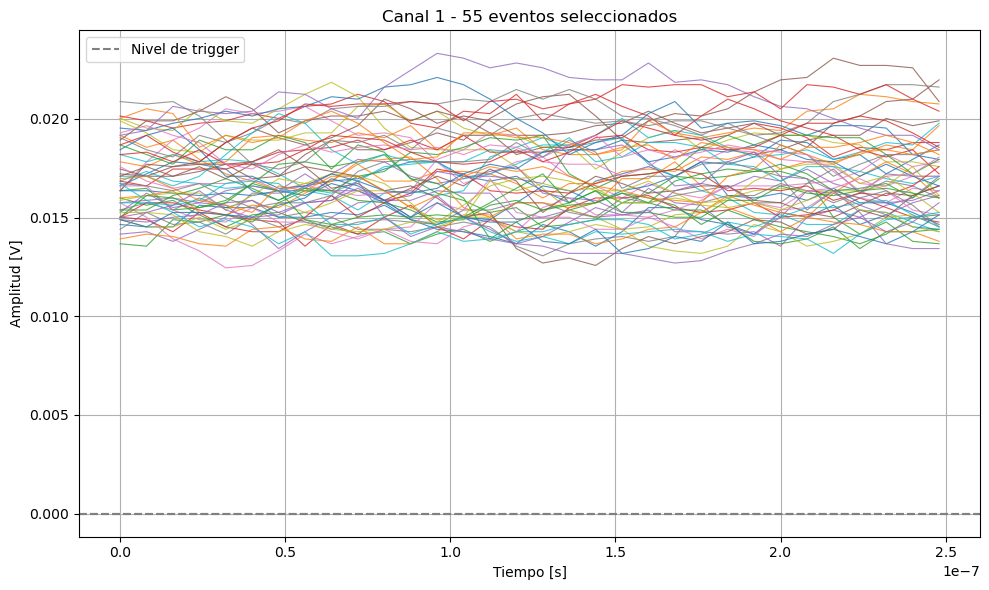

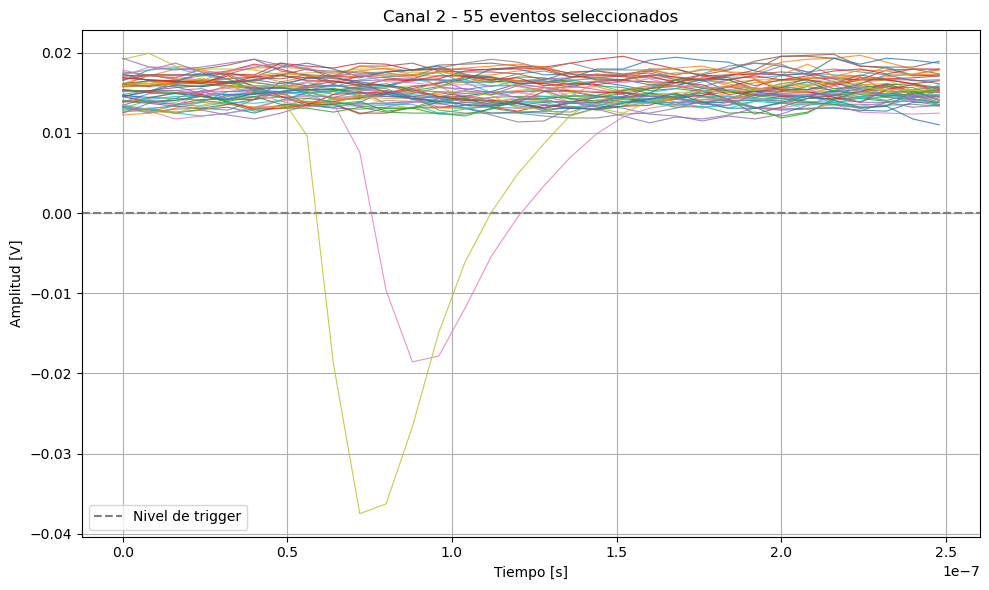

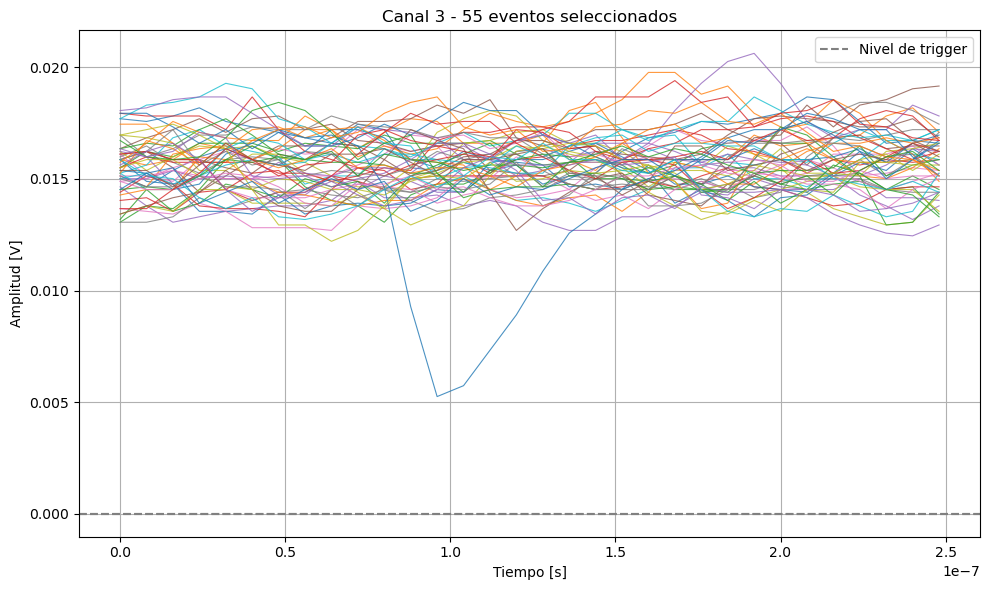

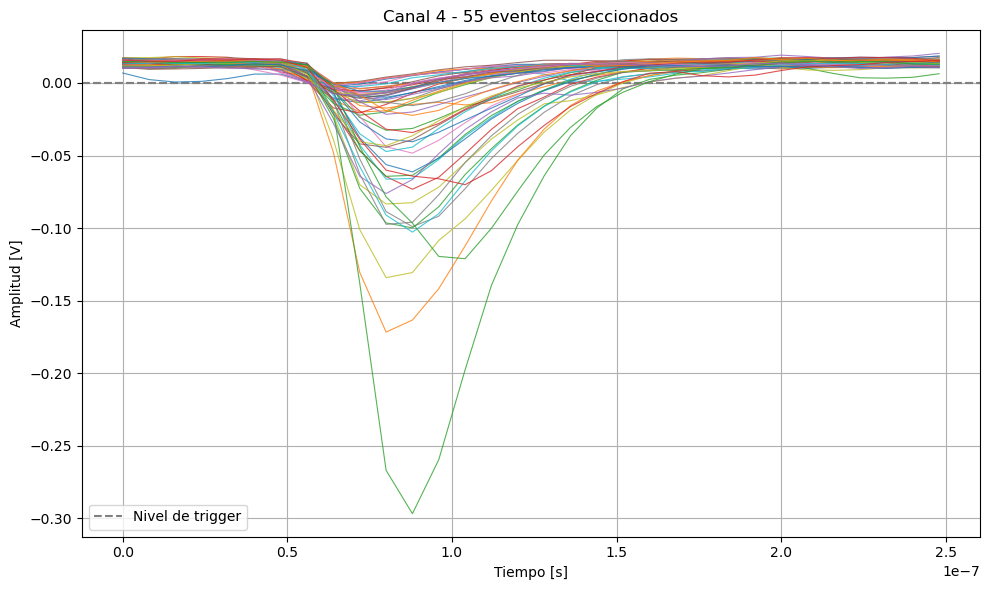

In [7]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# === 1. Buscar archivos .h5 en subdirectorios ===

# 📂 Carpeta base (donde están los subdirectorios con los archivos)
SOURCE_DIR = pathlib.Path("/home/jupyter/RedPitaya/DATOS").resolve()
print(f"📁 Buscando archivos .h5 en subdirectorios de: {SOURCE_DIR}\n")

# Buscar recursivamente en todos los subdirectorios
h5_files = list(SOURCE_DIR.rglob("*.h5"))

if not h5_files:
    raise FileNotFoundError("❌ No se encontraron archivos .h5 en los subdirectorios de la carpeta especificada.")

print("Archivos encontrados:")
for i, fpath in enumerate(h5_files):
    rel_path = fpath.relative_to(SOURCE_DIR)
    print(f"  {i}: {rel_path}")

# === 2. Seleccionar archivo ===
idx = int(input("\nSelecciona el número de archivo a abrir: "))
filename = h5_files[idx]
print(f"\n📂 Abriendo archivo: {filename}\n")

# === 3. Abrir archivo y mostrar metadata ===
with h5py.File(filename, "r") as f:
    print("=== METADATA ===")
    for k, v in f.attrs.items():
        print(f"{k:20s} : {v}")

    fs = f.attrs["sampling_rate"]
    samples = f.attrs["samples_per_event"]
    trig_lvl = f.attrs["trigger_level"]
    channels = f.attrs["channels"]

    # Eje de tiempo
    dt = 1 / fs
    time_axis = np.linspace(0, (samples - 1) * dt, samples)

    # === 4. Recorrer todos los eventos y graficar ===
    events = sorted([key for key in f.keys() if key.startswith("event_")])
    total_events = len(events)
    print(f"\nEl archivo contiene {total_events} eventos.\n")

    # Preguntar cuántos eventos graficar
    try:
        n_to_plot = int(input("¿Cuántos eventos desea graficar?: "))
        if n_to_plot <= 0:
            raise ValueError
    except ValueError:
        print("Entrada no válida, se graficará solo 1 evento.")
        n_to_plot = 1

    # Ajustar si hay menos eventos de los que se pidió
    n_to_plot = min(n_to_plot, total_events)

    # Seleccionar eventos espaciados uniformemente
    if total_events == 1:
        selected_events = [events[0]]
    else:
        indices = np.linspace(0, total_events - 1, n_to_plot, dtype=int)
        selected_events = [events[i] for i in indices]

    print(f"\nSe graficarán {len(selected_events)} eventos equiespaciados del total registrado\n")

    # === 5. Graficar ===
    for ch in channels:
        plt.figure(figsize=(10, 6))
        plt.title(f"Canal {ch} - {n_to_plot} eventos seleccionados")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud [V]")

        # Líneas de nivel de trigger
        plt.axhline(y=trig_lvl, color="gray", linestyle="--", label="Nivel de trigger")
        plt.axhline(y=-trig_lvl, color="gray", linestyle="--")

        # Graficar eventos seleccionados
        for ev in selected_events:
            data = f[f"{ev}/channel_{ch}"][:]
            plt.plot(time_axis, data, linewidth=0.8, alpha=0.8)

        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
